In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import gc
import time
import re
import unicodedata

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras import backend as K

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

In [3]:
# Global parameters
#root folder
root_folder='/content/drive/MyDrive/machine-translation/'
#data_folder='.'
data_folder_name='corpus/spa-eng'
train_filename='spa.txt'

# Variable for data directory
DATA_PATH = os.path.abspath(os.path.join(root_folder, data_folder_name))
train_filenamepath = os.path.abspath(os.path.join(DATA_PATH, train_filename))

# Both train and test set are in the root data directory
train_path = DATA_PATH
test_path = DATA_PATH

In [4]:
train_filenamepath

'/content/drive/MyDrive/machine-translation/corpus/spa-eng/spa.txt'

In [7]:
# Parameters for our model
INPUT_COLUMN = 'input'
TARGET_COLUMN = 'target'
TARGET_FOR_INPUT = 'target_for_input'
NUM_SAMPLES = 100000 #40000
MAX_VOCAB_SIZE = 20000
EMBEDDING_DIM = 128
HIDDEN_DIM = 1024 #512

BATCH_SIZE = 128  # Batch size for training.
EPOCHS = 20  # Number of epochs to train for.

ATTENTION_FUNC='general'

In [8]:
#Preprocessing the data
# Some function to preprocess the text data, taken from the Neural machine translation with attention tutorial in Tensorflow
def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn')

def preprocess_sentence(w):
    ''' Preprocess the input text w applying lowercase, removing accents, 
    creating a space between a word and the punctuation following it and 
    replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    Input:
        - w: a string, input text
    Output:
        - a string, the cleaned text
    '''
    w = unicode_to_ascii(w.lower().strip())

    # creating a space between a word and the punctuation following it
    # eg: "he is a boy." => "he is a boy ."
    # Reference:- https://stackoverflow.com/questions/3645931/python-padding-punctuation-with-white-spaces-keeping-punctuation
    w = re.sub(r"([?.!,¿])", r" \1 ", w)
    w = re.sub(r'[" "]+', " ", w)

    # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")
    w = re.sub(r"[^a-zA-Z?.!,¿]+", " ", w)

    w = w.strip()

    # adding a start and an end token to the sentence
    # so that the model know when to start and stop predicting.
    #w = '<start> ' + w + ' <end>'
    
    return w

In [14]:
# Load the dataset: sentence in english, sentence in spanish 
df=pd.read_csv(train_filenamepath, sep="\t", header=None, names=[TARGET_COLUMN,INPUT_COLUMN], usecols=[0,1], 
               nrows=NUM_SAMPLES)
# Preprocess the input data
input_data=df[INPUT_COLUMN].apply(lambda x : preprocess_sentence(x)).tolist()
# Preprocess and include the end of sentence token to the target text
target_data=df[TARGET_COLUMN].apply(lambda x : preprocess_sentence(x)+ ' <eos>').tolist()
# Preprocess and include a start of setence token to the input text to the decoder, it is rigth shifted
target_input_data=df[TARGET_COLUMN].apply(lambda x : '<sos> '+ preprocess_sentence(x)).tolist()

print(input_data[:5])
print(target_data[:5])
print(target_input_data[:5])

['ve .', 'vete .', 'vaya .', 'vayase .', 'hola .']
['go . <eos>', 'go . <eos>', 'go . <eos>', 'go . <eos>', 'hi . <eos>']
['<sos> go .', '<sos> go .', '<sos> go .', '<sos> go .', '<sos> hi .']


In [17]:
df

,target,input
0,Go.,Ve.
1,Go.,Vete.
2,Go.,Vaya.
3,Go.,Váyase.
4,Hi.,Hola.
...,...,...
99995,I can't see very well without glasses.,No veo muy bien sin gafas.
99996,I can't see very well without glasses.,No puedo ver muy bien sin gafas.
99997,I can't stop thinking about yesterday.,No puedo dejar de pensar en lo de ayer.
99998,I can't tell if you're serious or not.,Yo no puedo decir si tú eres serio o no.


In [23]:
# Create a tokenizer for the input texts(Spanish) and fit it to them 
tokenizer_inputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_inputs.fit_on_texts(input_data)
# Tokenize and transform input texts to sequence of integers
input_sequences = tokenizer_inputs.texts_to_sequences(input_data)
# Claculate the max length
input_max_len = max(len(s) for s in input_sequences)
print('Max Input Length: ', input_max_len)
# Show some example of tokenize sentences, useful to check the tokenization
print(input_data[19995])
print(input_sequences[19995])


Max Input Length:  20
¿ hay un problema ?
[6, 64, 12, 165, 5]


In [24]:
# tokenize the outputs(English)
# don't filter out special characters (filters = '')
# otherwise <sos> and <eos> won't appear
# By default, Keras’ Tokenizer will trim out all the punctuations, which is not what we want. 
# we can just set filters as blank here.

# Create a tokenizer for the output texts and fit it to them 
tokenizer_outputs = Tokenizer(num_words=MAX_VOCAB_SIZE, filters='')
tokenizer_outputs.fit_on_texts(target_data)
tokenizer_outputs.fit_on_texts(target_input_data)
# Tokenize and transform output texts to sequence of integers
target_sequences = tokenizer_outputs.texts_to_sequences(target_data)
target_sequences_inputs = tokenizer_outputs.texts_to_sequences(target_input_data)

# determine maximum length output sequence
target_max_len = max(len(s) for s in target_sequences)
print('Max Target Length: ', target_max_len)

print(target_data[19995])
print(target_sequences[19995])
print(target_input_data[19995])
print(target_sequences_inputs[19995])

Max Target Length:  14
is there a problem ? <eos>
[11, 50, 10, 223, 9, 2]
<sos> is there a problem ?
[3, 11, 50, 10, 223, 9]


In [25]:
#Creating Vocabularies
# get the word to index mapping for input language
word2idx_inputs = tokenizer_inputs.word_index
print('Found %s unique input tokens.' % len(word2idx_inputs))

# get the word to index mapping for output language
word2idx_outputs = tokenizer_outputs.word_index
print('Found %s unique output tokens.' % len(word2idx_outputs))

# store number of output and input words for later
# remember to add 1 since indexing starts at 1
num_words_output = len(word2idx_outputs) + 1
num_words_inputs = len(word2idx_inputs) + 1

# map indexes back into real words
# so we can view the results
idx2word_inputs = {v:k for k, v in word2idx_inputs.items()}
idx2word_outputs = {v:k for k, v in word2idx_outputs.items()}

Found 20025 unique input tokens.
Found 10333 unique output tokens.


In [26]:
#Padding - necessary to pad the sentences with 0 at the end so all the sentences have the smae length
# pad the input sequences
encoder_inputs = pad_sequences(input_sequences, maxlen=input_max_len, padding='post')
print("encoder_inputs.shape:", encoder_inputs.shape)
print("encoder_inputs[0]:", encoder_inputs[0])
# pad the decoder input sequences
decoder_inputs = pad_sequences(target_sequences_inputs, maxlen=target_max_len, padding='post')
print("decoder_inputs[0]:", decoder_inputs[0])
print("decoder_inputs.shape:", decoder_inputs.shape)
# pad the target output sequences
decoder_targets = pad_sequences(target_sequences, maxlen=target_max_len, padding='post')

encoder_inputs.shape: (100000, 20)
encoder_inputs[0]: [281   1   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0]
decoder_inputs[0]: [ 3 46  1  0  0  0  0  0  0  0  0  0  0  0]
decoder_inputs.shape: (100000, 14)


In [27]:
# Define a dataset 
dataset = tf.data.Dataset.from_tensor_slices(
    (encoder_inputs, decoder_inputs, decoder_targets))
dataset = dataset.shuffle(len(input_data)).batch(
    BATCH_SIZE, drop_remainder=True)

In [29]:
class Encoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Encoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)

    def call(self, input_sequence, states):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        output, state_h, state_c = self.lstm(embed, initial_state=states)

        return output, state_h, state_c

    def init_states(self, batch_size):
        # Return a all 0s initial states
        return (tf.zeros([batch_size, self.hidden_dim]),
                tf.zeros([batch_size, self.hidden_dim]))

In [30]:
class Decoder(tf.keras.Model):
    def __init__(self, vocab_size, embedding_dim, hidden_dim):
        super(Decoder, self).__init__()
        self.hidden_dim = hidden_dim
        # Define the embedding layer
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_dim)
        # Define the RNN layer, LSTM
        self.lstm = tf.keras.layers.LSTM(
            hidden_dim, return_sequences=True, return_state=True)
        self.dense = tf.keras.layers.Dense(vocab_size)

    def call(self, input_sequence, state):
        # Embed the input
        embed = self.embedding(input_sequence)
        # Call the LSTM unit
        lstm_out, state_h, state_c = self.lstm(embed, state)
        # Dense layer to predict output token
        logits = self.dense(lstm_out)

        return logits, state_h, state_c

In [31]:
#Set the length of the input and output vocabulary
num_words_inputs = len(word2idx_inputs) + 1
num_words_output = len(word2idx_outputs) + 1
#Create the encoder
encoder = Encoder(num_words_inputs, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
initial_state = encoder.init_states(1)
# Call the encoder for testing
test_encoder_output = encoder(tf.constant(
    [[1, 23, 4, 5, 0, 0]]), initial_state)
print(test_encoder_output[0].shape)
# Create the decoder
decoder = Decoder(num_words_output, EMBEDDING_DIM, HIDDEN_DIM)
# Get the initial states
de_initial_state = test_encoder_output[1:]
# Call the decoder for testing
test_decoder_output = decoder(tf.constant(
    [[1, 3, 5, 7, 9, 0, 0, 0]]), de_initial_state)
print(test_decoder_output[0].shape)

(1, 6, 1024)
(1, 8, 10334)


In [32]:
def loss_func(targets, logits):
    crossentropy = tf.keras.losses.SparseCategoricalCrossentropy(
        from_logits=True)
    # Mask padding values, they do not have to compute for loss
    mask = tf.math.logical_not(tf.math.equal(targets, 0))
    mask = tf.cast(mask, dtype=tf.int64)
    # Calculate the loss value
    loss = crossentropy(targets, logits, sample_weight=mask)

    return loss

def accuracy_fn(y_true, y_pred):
    # y_pred shape is batch_size, seq length, vocab size
    # y_true shape is batch_size, seq length
    pred_values = K.cast(K.argmax(y_pred, axis=-1), dtype='int32')
    correct = K.cast(K.equal(y_true, pred_values), dtype='float32')

    # 0 is padding, don't include those
    mask = K.cast(K.greater(y_true, 0), dtype='float32')
    n_correct = K.sum(mask * correct)
    n_total = K.sum(mask)
  
    return n_correct / n_total

In [33]:
# Use the @tf.function decorator to take advance of static graph computation
@tf.function
def train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer):
    ''' A training step, train a batch of the data and return the loss value reached
        Input:
        - input_seq: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence
        - target_seq_out: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the target seq, our target sequence
        - target_seq_in: array of integers, shape [batch_size, max_seq_len, embedding dim].
            the input sequence to the decoder, we use Teacher Forcing
        - en_initial_states: tuple of arrays of shape [batch_size, hidden_dim].
            the initial state of the encoder
        - optimizer: a tf.keras.optimizers.
        Output:
        - loss: loss value
        
    '''
    # Network’s computations need to be put under tf.GradientTape() to keep track of gradients
    with tf.GradientTape() as tape:
        # Get the encoder outputs
        en_outputs = encoder(input_seq, en_initial_states)
        # Set the encoder and decoder states
        en_states = en_outputs[1:]
        de_states = en_states
        # Get the encoder outputs
        de_outputs = decoder(target_seq_in, de_states)
        # Take the actual output
        logits = de_outputs[0]
        # Calculate the loss function
        loss = loss_func(target_seq_out, logits)
        acc = accuracy_fn(target_seq_out, logits)

    variables = encoder.trainable_variables + decoder.trainable_variables
    # Calculate the gradients for the variables
    gradients = tape.gradient(loss, variables)
    # Apply the gradients and update the optimizer
    optimizer.apply_gradients(zip(gradients, variables))

    return loss, acc

In [34]:
# Create the main train function
def main_train(encoder, decoder, dataset, n_epochs, batch_size, optimizer, checkpoint, checkpoint_prefix):
    
    losses = []
    accuracies = []

    for e in range(n_epochs):
        # Get the initial time
        start = time.time()
        # Get the initial state for the encoder
        en_initial_states = encoder.init_states(batch_size)
        # For every batch data
        for batch, (input_seq, target_seq_in, target_seq_out) in enumerate(dataset.take(-1)):
            # Train and get the loss value 
            loss, accuracy = train_step(input_seq, target_seq_in, target_seq_out, en_initial_states, optimizer)
        
            if batch % 100 == 0:
                # Store the loss and accuracy values
                losses.append(loss)
                accuracies.append(accuracy)
                print('Epoch {} Batch {} Loss {:.4f} Acc:{:.4f}'.format(e + 1, batch, loss.numpy(), accuracy.numpy()))
                
        # saving (checkpoint) the model every 2 epochs
        if (e + 1) % 2 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)
    
        print('Time taken for 1 epoch {:.4f} sec\n'.format(time.time() - start))
        
    return losses, accuracies

In [35]:
# Create an Adam optimizer and clips gradients by norm
optimizer = tf.keras.optimizers.Adam(clipnorm=5.0)
# Create a checkpoint object to save the model
checkpoint_dir = '/content/drive/MyDrive/machine-translation/models/spa-eng/training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(optimizer=optimizer,
                                 encoder=encoder,
                                 decoder=decoder)

losses, accuracies = main_train(encoder, decoder, dataset, EPOCHS, BATCH_SIZE, optimizer, checkpoint, checkpoint_prefix)

Epoch 1 Batch 0 Loss 4.9619 Acc:0.0000
Epoch 1 Batch 100 Loss 2.4552 Acc:0.3007
Epoch 1 Batch 200 Loss 2.2804 Acc:0.3186
Epoch 1 Batch 300 Loss 2.0306 Acc:0.3700
Epoch 1 Batch 400 Loss 2.1268 Acc:0.3613
Epoch 1 Batch 500 Loss 1.9255 Acc:0.3900
Epoch 1 Batch 600 Loss 1.8468 Acc:0.4056
Epoch 1 Batch 700 Loss 1.7278 Acc:0.4387
Time taken for 1 epoch 79.7817 sec

Epoch 2 Batch 0 Loss 1.7063 Acc:0.4519
Epoch 2 Batch 100 Loss 1.6150 Acc:0.4586
Epoch 2 Batch 200 Loss 1.5352 Acc:0.4771
Epoch 2 Batch 300 Loss 1.5399 Acc:0.4852
Epoch 2 Batch 400 Loss 1.4996 Acc:0.4894
Epoch 2 Batch 500 Loss 1.5496 Acc:0.4781
Epoch 2 Batch 600 Loss 1.4517 Acc:0.5021
Epoch 2 Batch 700 Loss 1.3808 Acc:0.5124
Time taken for 1 epoch 77.2721 sec

Epoch 3 Batch 0 Loss 1.3096 Acc:0.5069
Epoch 3 Batch 100 Loss 1.2552 Acc:0.5304
Epoch 3 Batch 200 Loss 1.3219 Acc:0.5513
Epoch 3 Batch 300 Loss 1.2760 Acc:0.5361
Epoch 3 Batch 400 Loss 1.1697 Acc:0.5675
Epoch 3 Batch 500 Loss 1.1905 Acc:0.5655
Epoch 3 Batch 600 Loss 1.2795 Ac

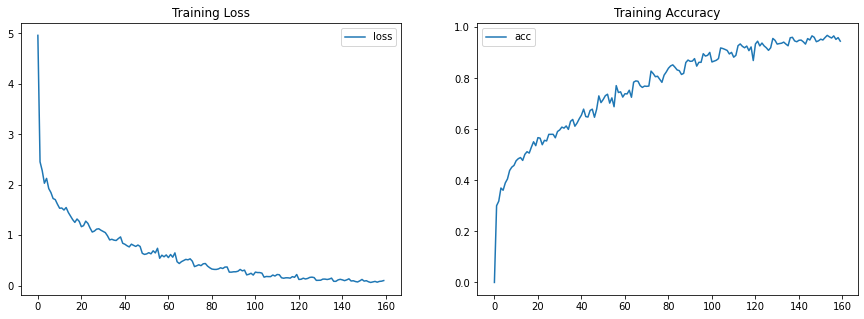

In [38]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
# plot some data
ax1.plot(losses, label='loss')
#plt.plot(results.history['val_loss'], label='val_loss')
ax1.set_title('Training Loss')
ax1.legend()
# accuracies
ax2.plot(accuracies, label='acc')
#plt.plot(results.history['val_accuracy_fn'], label='val_acc')
ax2.set_title('Training Accuracy')
ax2.legend()
plt.show()

In [39]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint_dir = '/content/drive/MyDrive/machine-translation/models/spa-eng/training_ckpt_seq2seq'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

In [40]:
def predict(input_text, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs):
    if input_text is None:
        input_text = input_data[np.random.choice(len(input_data))]
        print(input_text)
    # Tokenize the input sequence
    input_seq = tokenizer_inputs.texts_to_sequences([input_text])
    # Pad the sentence
    input_seq = pad_sequences(input_seq, maxlen=input_max_len, padding='post')
    print(input_seq)
    # Set the encoder initial state
    en_initial_states = encoder.init_states(1)
    en_outputs = encoder(tf.constant(input_seq), en_initial_states)
    # Create the decoder input, the sos token
    de_input = tf.constant([[word2idx_outputs['<sos>']]])
    # Set the decoder states to the encoder vector or encoder hidden state
    de_state_h, de_state_c = en_outputs[1:]
    
    out_words = []
    while True:
        # Decode and get the output probabilities
        de_output, de_state_h, de_state_c = decoder(
            de_input, (de_state_h, de_state_c))
        # Select the word with the highest probability
        de_input = tf.argmax(de_output, -1)
        # Append the word to the predicted output
        out_words.append(idx2word_outputs[de_input.numpy()[0][0]])
        # Finish when eos token is found or the max length is reached
        if out_words[-1] == '<eos>' or len(out_words) >= 20:
            break

    print(' '.join(out_words))

In [47]:
test_sents = [input_data[5000], input_data[10000], input_data[15000], input_data[20000],
input_data[25000], input_data[30000], input_data[35000], input_data[40000], input_data[45000], input_data[50000], 
input_data[55000], input_data[60000], input_data[65000], input_data[70000], input_data[75000], input_data[80000],
input_data[85000], input_data[90000], input_data[95000]]
#test_sents = [encoder_inputs[1000]]
print(test_sents)
for test_sent in test_sents:
    predict(test_sent, encoder, input_max_len, tokenizer_inputs, word2idx_outputs, idx2word_outputs)

['tengo que intentarlo .', 'eso es increible !', '¿ teneis un carro ?', '¿ esta es la mujer de tom ?', 'dile a tom que se presente .', 'tom perdio las gafas .', '¿ que puedo hacer por ustedes ?', '¿ donde estudias ?', 'deberias ir personalmente .', 'un cocodrilo se comio a tom .', '¿ tienes alguna experiencia ?', 'el estuvo muy malhumorado anoche .', '¿ cuanto dinero tiene tom ?', 'solo quiero volverme a la cama .', 'soy el benjamin de la familia .', 'ahora lleva puesto un precioso vestido .', 'ayer , tom no tenia nada para comer .', 'todo el mundo quiere vivir confortablemente .', 'los soldados deben obedecer a sus comandantes .']
[[  40    2 1292    1    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
i have to try . <eos>
[[  31   11 1932   53    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0]]
it s incredible ! <eos>
[[  6 800  12 713   5   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0]]
do you have a ca